# MKTG 685 - Machine Learning in Marketing (Machine Learning)
# Advanced NLP: Deep Learing-based NLP (Intention Mining)

Hyunhwan "Aiden" Lee

> Assistant Professor of Marketing, College of Business, California State University Long Beach

Copyright (c) 2021 ~ present

In this homework, we will create a brand perceptual map usign topic modeling and sentiment analysis. Through this homework, you will review what we studied so far in text mining and natural language processing. Please follow the code in the next lines.

To complete this assingment, please "save a copy in Drive" and complete the codes.
Also, run all the codes before you submit.
Then, submit your "ipynb" file on Canvas.
**If your codes do not work or you missed/deleted output in a cell, you will not get points from the cell.**

If you have any questions, please contact to our TA.

I would like to let you know that the code for this assignment has been fully tested and should run smoothly on Google Colab's free tier. If you come across any errors, especially in cells where you don't need to change the code, please take a moment to review your code before that cell. If you have any questions or need assistance, feel free to reach out to our TA or me. When asking about the assignment, it's helpful if you can share your Colab code link, as screenshots may not provide enough context for us to identify the issue.

[Before we start] To run this code efficiently, I highly recommend to use GPU runtime instead of CPU. Pelase choose GPU in Runtime setting. To check wehther you correctly choose GPU or not, run the test codes below.

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
import tensorflow as tf
import torch

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    print(gpu_info)
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Wed May  8 17:53:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              27W /  70W |    103MiB / 15360MiB |      2%      Default |
|                                         |                      |    

## BERT-based Intention Mining

This Python programming assignment is designed to help you consolidate your understanding of the powerful transformer models, the BERT model, and multi-label classification, and apply these concepts to the real-world task of intention mining.

Intention mining, also known as intent recognition, is a critical aspect of natural language processing (NLP) that deals with identifying the purpose or goal of a given text. With the rise of digital communication, it has become increasingly important to accurately understand user intentions in order to provide relevant responses or services.

In this assignment, you will leverage the power of BERT (Bidirectional Encoder Representations from Transformers) to create a state-of-the-art intention mining system. BERT, a pre-trained transformer-based model, has revolutionized NLP by offering unparalleled performance on a wide range of tasks. Its bidirectional training and contextual understanding capabilities make it an ideal choice for our task of multi-label classification in intention mining.

Your primary objective will be to implement a BERT-based model that can classify intentions from a given dataset into multiple labels. You will start by exploring the dataset, pre-processing the text, and preparing it for use with the BERT model. Then, you will fine-tune the BERT model for the intention mining task and evaluate its performance using appropriate metrics. Lastly, you will analyze your model's results and draw conclusions about its effectiveness in intention mining.

By the end of this assignment, you will have a deeper understanding of the inner workings of transformer models, BERT, and intention mining. You will also gain hands-on experience in fine-tuning BERT for a specific NLP task, multi-label classification, and evaluating its performance. So, let's get started on this fascinating journey and harness the power of BERT to uncover user intentions!

Install required packages.

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
# requirement
# If needed, you should restart runtime. Monitor your output in this cell.
# After restart runtime, please check wehter packages were installed correctly by running this cell again.
!pip3 install transformers
!pip3 install tokenizers
!pip3 install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


Import required packages.

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import urllib.request

import pandas as pd
import numpy as np
import random
import time
import datetime

Download and load train and test datasets.

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_train_data.csv", filename="intent_train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_test_data.csv", filename="intent_test_data.csv")

intent_train_data = pd.read_csv('intent_train_data.csv')
intent_test_data = pd.read_csv('intent_test_data.csv')

**[Q]** Print tottal records of `intent_train_data`

In [ ]:
# Complete the following code
print(len(intent_train_data))

11784


* expected result: `11784`

**[Q]** print first five records of `intent_test_data`

In [ ]:
# Complete the following code
intent_test_data.head()

,intent,label
0,i 'd like to have this track onto my classical...,AddToPlaylist
1,add the album to my flow espa ol playlist,AddToPlaylist
2,add digging now to my young at heart playlist,AddToPlaylist
3,add this song by too poetic to my piano ballad...,AddToPlaylist
4,add this album to old school death metal,AddToPlaylist


* expected result

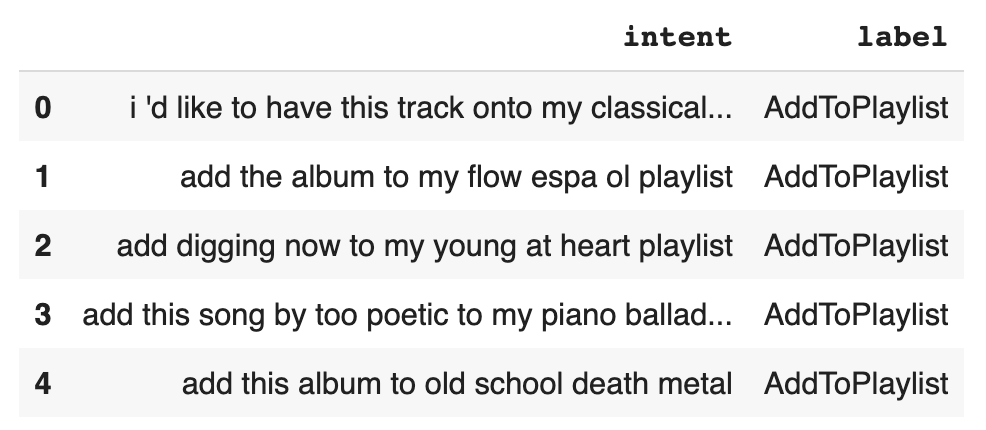

**[Q]** Make each list of `intent` and `label` columns from both `train_data` and `test_data`.

In [ ]:
# Complete the following code
train_intent = intent_train_data['intent'].tolist()
train_label = intent_train_data['label'].tolist()
test_intent = intent_test_data['intent'].tolist()
test_label = intent_test_data['label'].tolist()

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
print('Total number of sentences for training :', len(train_intent))
print('Total number of labels for training :', len(train_label))
print('Total number of sentences for testing :', len(test_intent))
print('Total number of labels for testing :', len(test_label))

Total number of sentences for training : 11784
Total number of labels for training : 11784
Total number of sentences for testing : 600
Total number of labels for testing : 600


* expected result:

`Total number of sentences for training : 11784`  
`Total number of labels for training : 11784`  
`Total number of sentences for testing : 600`  
`Total number of labels for testing : 600`

In [ ]:
# Complete the following code
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

train_label = idx_encode.transform(train_label)
test_label = idx_encode.transform(test_label)

# !!! DO NOT CHANGE THE CODE BELOW!!!
label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('Mapping labels:',label_idx)

Mapping labels: {'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


* expected result: `Mapping labels: {'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}`

In [ ]:
# Complete the following code
train_sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in train_intent]

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
train_sentences[0]

'[CLS] add another song to the cita rom ntica playlist [SEP]'

* expected result: `[CLS] add another song to the cita rom ntica playlist [SEP]`

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
train_label

array([0, 0, 0, ..., 5, 5, 5])

**[Q]** Use `bert-base-multilingual-cased` model

In [ ]:
# Complete the following code
model = 'bert-base-multilingual-cased'

**[Q]** Use `train_intent` dataset to create `train_tokenized_text`.

In [ ]:
# Complete the following code
tokenizer = BertTokenizer.from_pretrained(model, do_lower_case=False)
train_tokenized_texts = [tokenizer.tokenize(sent) for sent in train_intent]

# !!! DO NOT CHANGE THE CODE BELOW!!!
print (train_intent[0])
print (train_tokenized_texts[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

add another song to the cita rom ntica playlist
['add', 'another', 'song', 'to', 'the', 'cita', 'rom', 'nt', '##ica', 'play', '##list']


* part of the expected result:   

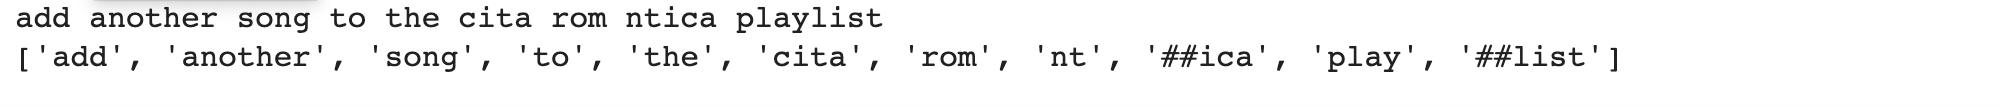


**[Q]** Set `64` as max length of the tokens. And create `input_ids` from `train_tokenized_texts` with zero paddings.

In [ ]:
# Complete the following code
MAX_LEN = 64
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# !!! DO NOT CHANGE THIS CODE !!!
input_ids[0]

array([42852, 12864, 12011, 10114, 10105, 37221, 86945, 86459, 11043,
       12253, 21476,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

* expected result:

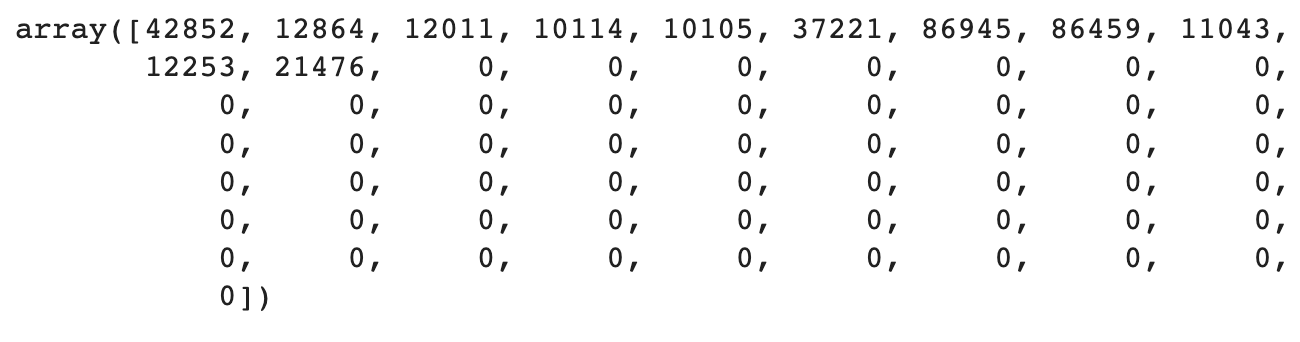

**[Q]** Create `attention_masks`.

In [ ]:
# Complete the following code
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# !!! DO NOT CHANGE THIS CODE !!!
print(len(attention_masks[0]))

64


* expected result: `64`

**[Q]** Use 10% of the train datasets for validation in the code below.

In [ ]:
# Complete the following code
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
  input_ids,
  train_label,
  random_state=100,
  test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
  attention_masks,
  input_ids,
  random_state=100,
  test_size=0.1
)


# !!! DO NOT CHANGE THE CODE BELOW!!!
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([ 11897,  10911,  10105,  36761, 110240,  22024,  16138,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
tensor(4)
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([18344, 10105, 33166, 25512, 10108, 10105, 21736, 11366,   126, 12789,
            0,     0,     0,     0,     0,    

* expected result:

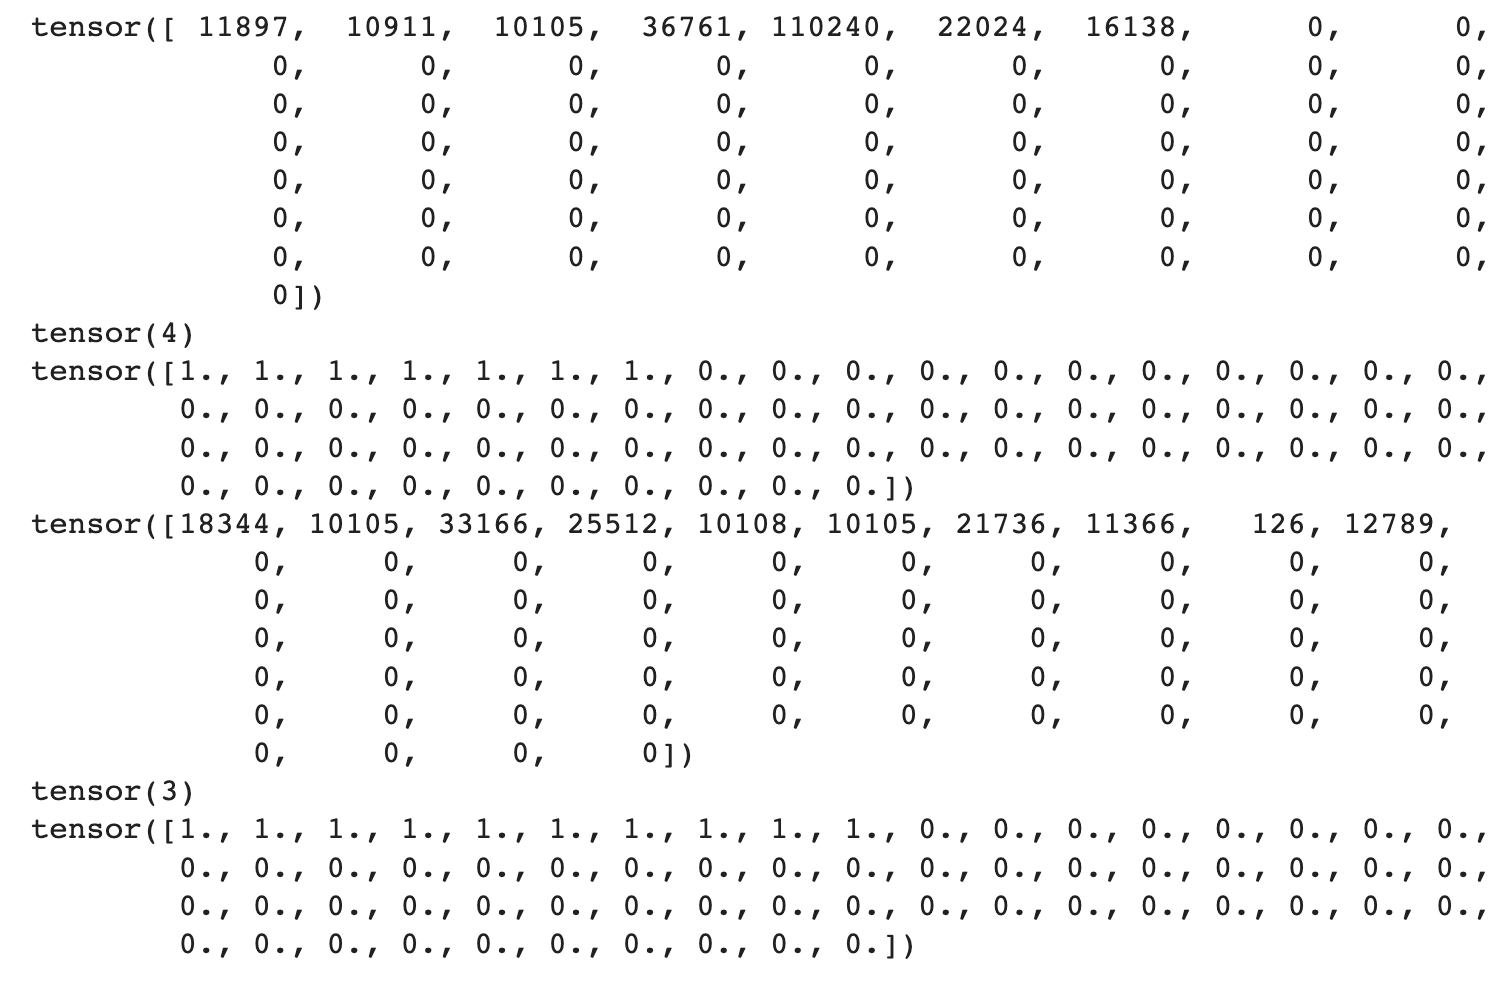

**[Q]** Complete the following code by setting `32` as batch size.

In [ ]:
# Complete the following code
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

**[Q]** Preprocess the test dataset

In [ ]:
# Complete the following code
test_sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in test_intent]

# !!! DO NOT CHANGE THE CODE BELOW!!!
test_sentences[:10]

["[CLS] i 'd like to have this track onto my classical relaxations playlist [SEP]",
 '[CLS] add the album to my flow espa ol playlist [SEP]',
 '[CLS] add digging now to my young at heart playlist [SEP]',
 '[CLS] add this song by too poetic to my piano ballads playlist [SEP]',
 '[CLS] add this album to old school death metal [SEP]',
 '[CLS] i need to add baro ferret to the urban hits under my name [SEP]',
 '[CLS] add the album to the might and myth power metal playlist [SEP]',
 '[CLS] to the travelling playlist , please add this david gahan song [SEP]',
 '[CLS] please add some pete townshend to my playlist fiesta hits con lali [SEP]',
 "[CLS] i 'd like for kasey chambers 's tune to be an addition to my chips and salsa playlist [SEP]"]

* expected result:

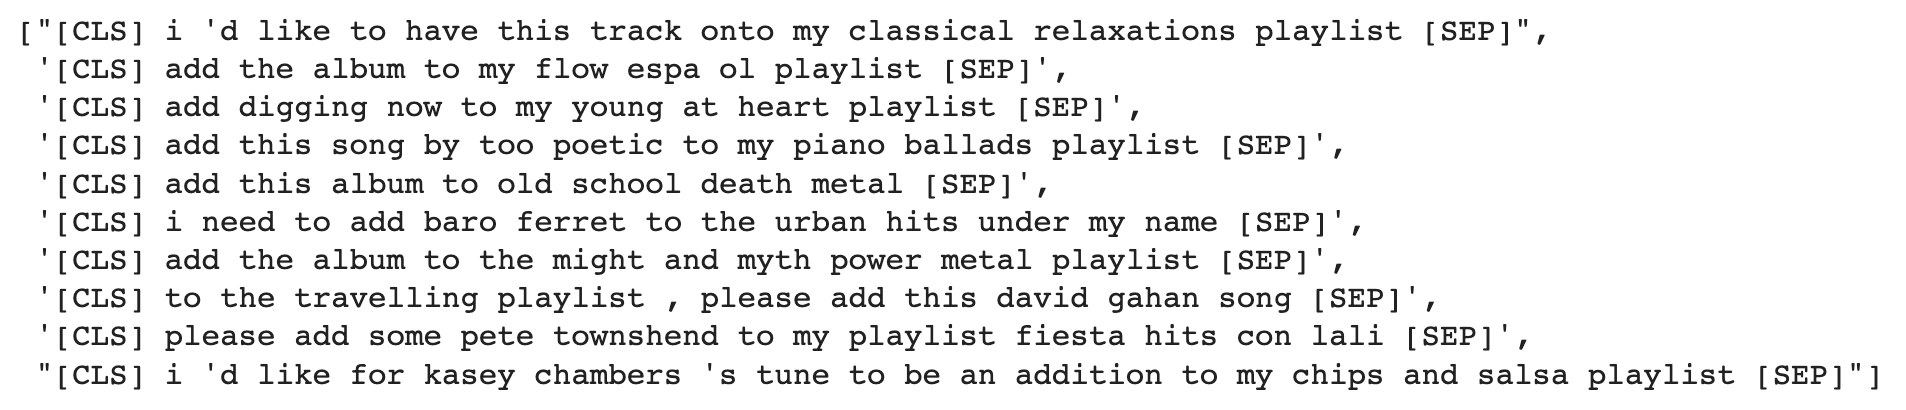

**[Q]** Create the tokenized texts from the test dataset.

In [ ]:
# Complete the following code
tokenizer = BertTokenizer.from_pretrained(model, do_lower_case=False)
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in test_intent]

# !!! DO NOT CHANGE THE CODE BELOW!!!
print(test_intent[0])
print(test_tokenized_texts[0])

i 'd like to have this track onto my classical relaxations playlist
['i', "'", 'd', 'like', 'to', 'have', 'this', 'track', 'onto', 'my', 'classical', 're', '##lax', '##ations', 'play', '##list']


* expected result:

`i 'd like to have this track onto my classical relaxations playlist`

`['i', "'", 'd', 'like', 'to', 'have', 'this', 'track', 'onto', 'my', 'classical', 're', '##lax', '##ations', 'play', '##list']`

**[Q]** Set `64` as max length of the tokens. And create `test_input_ids` from `test_tokenized_texts` with zero paddings.

In [ ]:
# Complete the following code
MAX_LEN = 64
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# !!! DO NOT CHANGE THE CODE BELOW!!!
test_input_ids[0]

array([  177,   112,   172, 11850, 10114, 10529, 10531, 14310, 31095,
       15127, 30427, 11639, 90001, 24965, 12253, 21476,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

* expected result:

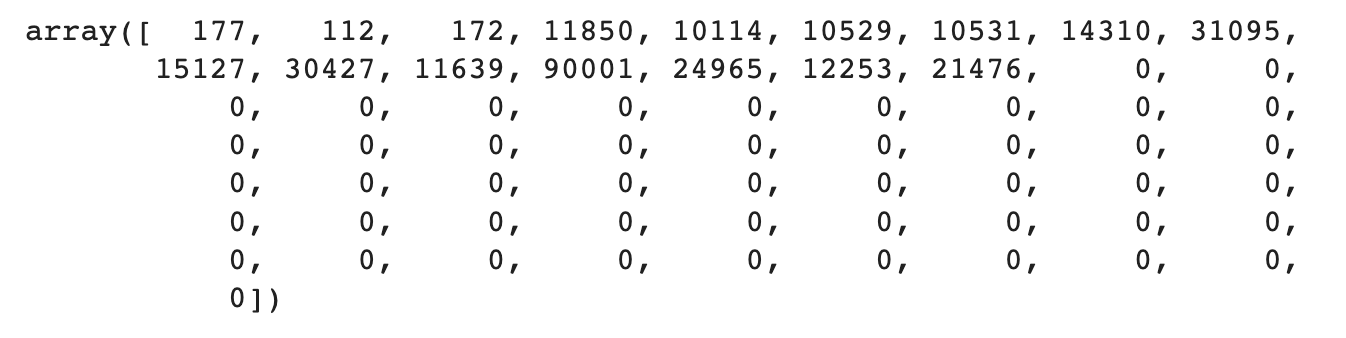

**[Q]** Create `test_attention_masks` by completing the following code.

In [ ]:
# Complete the following code
test_attention_masks = []
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

# !!! DO NOT CHANGE THE CODE BELOW!!!
print(len(test_attention_masks[0]))

64


* expected result: `64`

**[Q]** Create `tensor` using `PyTorch.tensor`.

In [ ]:
# Complete the following code
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_label)
test_masks = torch.tensor(test_attention_masks)

# !!! DO NOT CHANGE THE CODE BELOW!!!
print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([  177,   112,   172, 11850, 10114, 10529, 10531, 14310, 31095, 15127,
        30427, 11639, 90001, 24965, 12253, 21476,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
tensor(0)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


* expected result:

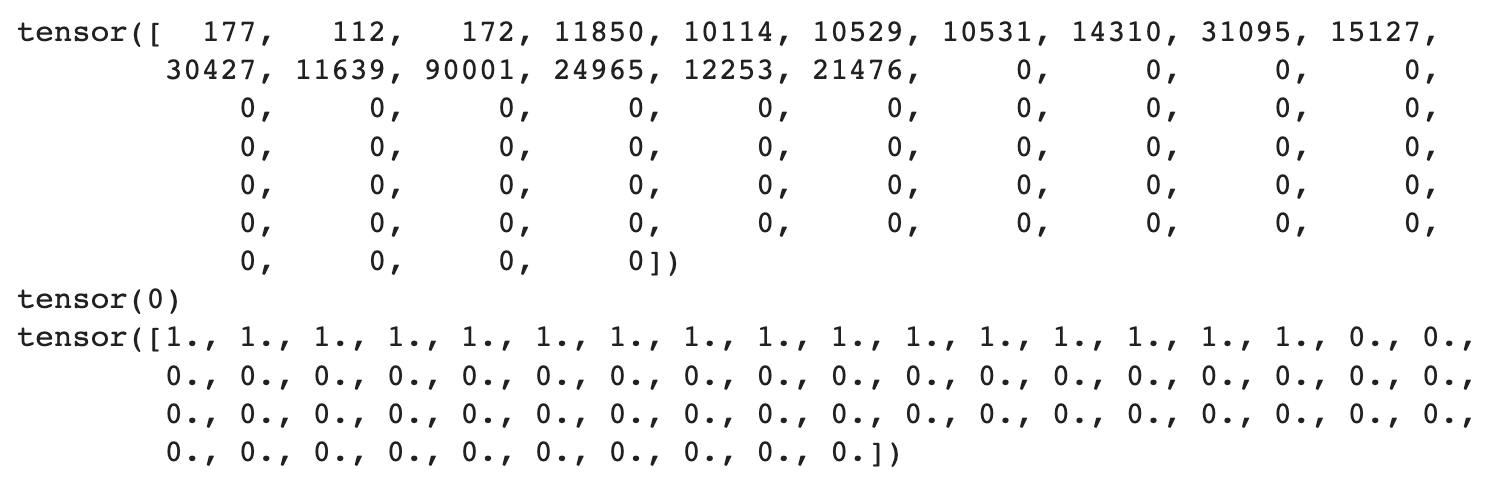

**[Q]** Complete the following code by setting `32` as batch size.

In [ ]:
# Complete the following code
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

**[Q]** Create a correct model for intention mining for the dataset you are using.

In [ ]:
# Complete the following code
model_intent = BertForSequenceClassification.from_pretrained(model, num_labels=6)

# !!! DO NOT CHANGE THE CODE BELOW!!!
model_intent.cuda()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

**[Q]** Create `Adam Optimizer` by completing the following code. Also, set `10` epochs to train the model.

In [ ]:
# Complete the following code
optimizer = AdamW(
    model_intent.parameters(),
    lr = 2e-5, # Learning rate
    eps = 1e-8 # To avoid to divide by 0
)

epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# !!! DO NOT CHANGE THIS CODE !!!
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model_intent.zero_grad()

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # initialize
    t0 = time.time()
    total_loss = 0
    model_intent.train()
    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # work in GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model_intent(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        # Backward gradient
        loss.backward()
        # clipping gradient
        torch.nn.utils.clip_grad_norm_(model_intent.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # schedule for learning rate
        scheduler.step()
        # reset gradient
        model_intent.zero_grad()
    # calculate average loss rate
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    # initialize
    t0 = time.time()
    model_intent.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model_intent(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)
        # loss
        logits = outputs[0]
        # calculate logits in CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # calculate accuracy
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}%".format((eval_accuracy/nb_eval_steps)*100))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...

  Average training loss: 0.37
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 98.73%
  Validation took: 0:00:04

======== Epoch 2 / 10 ========
Training...

  Average training loss: 0.04
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 99.16%
  Validation took: 0:00:04

======== Epoch 3 / 10 ========
Training...

  Average training loss: 0.03
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 98.99%
  Validation took: 0:00:04

======== Epoch 4 / 10 ========
Training...

  Average training loss: 0.02
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 98.99%
  Validation took: 0:00:04

======== Epoch 5 / 10 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 99.32%
  Validation took: 0:00:04

======== Epoch 6 / 10 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:01:58

Running Validation

Evaluate the test dataset

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
t0 = time.time()
model_intent.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for step, batch in enumerate(test_dataloader):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model_intent(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}%".format((eval_accuracy/nb_eval_steps)*100))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 98.85%
Test took: 0:00:02


Test new texts.

In [ ]:
# !!! DO NOT CHANGE THIS CODE !!!
def convert_input_data(sentences):
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    MAX_LEN = 64
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    return inputs, masks

def test_sentences(sentences):
    model_intent.eval()
    inputs, masks = convert_input_data(sentences)
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    with torch.no_grad():
        outputs = model_intent(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    return logits

In [ ]:
# !!! DO NOT CHANGE THE CODE BELOW!!!
new_text = [
  'add Dynamite on my favorites',
  'give one star',
  'hows the weather today',
  'search BTS concert',
  'serach Avatar film near 90840',
  'book Open Sesame in Long Beach'
]

**[Q]** Complete the following code to get the expected result as below:

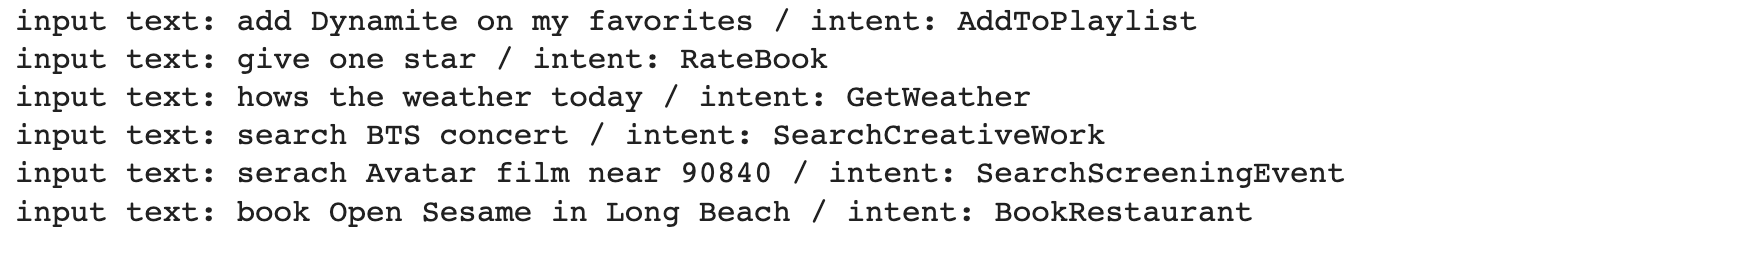

In [ ]:
# Complete the following code
for text in new_text:
  logits = test_sentences([text])
  print(f'input text: ' + text + ' / intent: ' + list(label_idx.keys())[logits[0].argmax().item()])

input text: add Dynamite on my favorites / intent: AddToPlaylist
input text: give one star / intent: RateBook
input text: hows the weather today / intent: GetWeather
input text: search BTS concert / intent: SearchCreativeWork
input text: serach Avatar film near 90840 / intent: SearchScreeningEvent
input text: book Open Sesame in Long Beach / intent: BookRestaurant
